In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

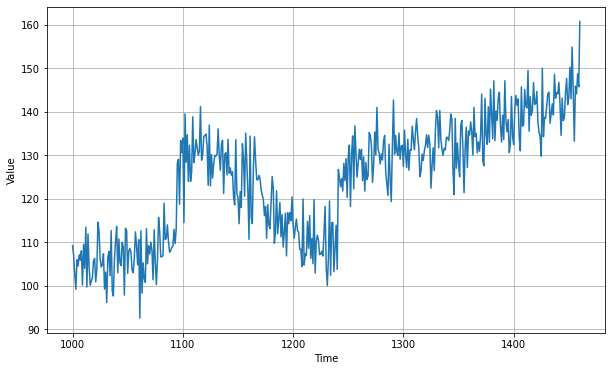

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, callbacks=[my_callbacks])


Epoch 1/100
31/31 [==============================] - 1s 12ms/step - loss: 832.6833
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 73.1728
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 51.2809
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 49.4275
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 49.0122
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 48.2848
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 47.3927
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 46.8572
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 46.9517
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 46.2463
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 45.7974
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 45.8529
Epoch 13/100
31/31 [===

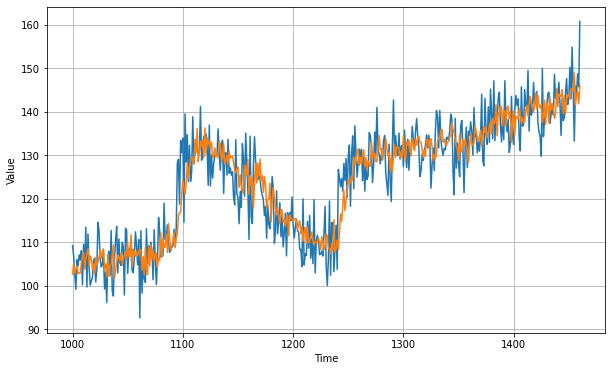

In [9]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6401157

In [12]:
rm -r *

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
checkpoint_filepath = '/tmp/checkpoint'



model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 4318.4521
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 197.1353
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 131.5744
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 128.9072
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 127.6837
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 126.7119
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 125.1473
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 123.7592
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 122.1512
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 120.2740
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 118.4818
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 116.1390
Epoch 13/100

(1e-08, 0.001, 0.0, 300.0)

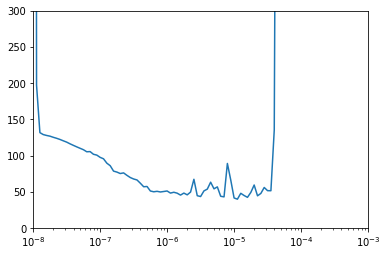

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [17]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

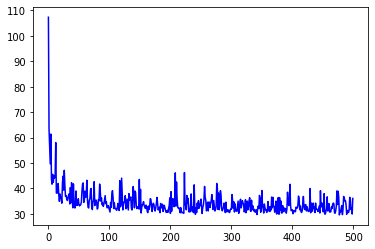

In [18]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[44.100975036621094, 44.84833526611328, 58.06037521362305, 38.20211410522461, 38.15707778930664, 38.249122619628906, 41.98118591308594, 37.46689987182617, 34.91937255859375, 37.826656341552734, 36.537227630615234, 36.10588836669922, 34.19685745239258, 42.14966583251953, 44.83945846557617, 39.34319305419922, 47.13140869140625, 41.06806564331055, 36.91966247558594, 37.16266632080078, 35.96759033203125, 35.272159576416016, 36.41956329345703, 37.13148880004883, 37.889225006103516, 33.8919792175293, 40.354835510253906, 34.39159393310547, 42.2297248840332, 35.937339782714844, 32.383419036865234, 41.7939338684082, 33.97006607055664, 32.3961296081543, 32.401119232177734, 39.013145446777344, 33.402103424072266, 34.985084533691406, 33.42435073852539, 35.9722785949707, 33.73554611206055, 33.12822723388672, 33.427772521972656, 33.62899398803711, 34.59219741821289, 38.97102355957031, 41.85844421386719, 42.170066833496094, 34.52061080932617, 35.672218322753906, 38.952938079833984, 36.482757568359375

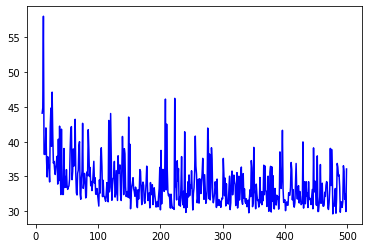

In [19]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

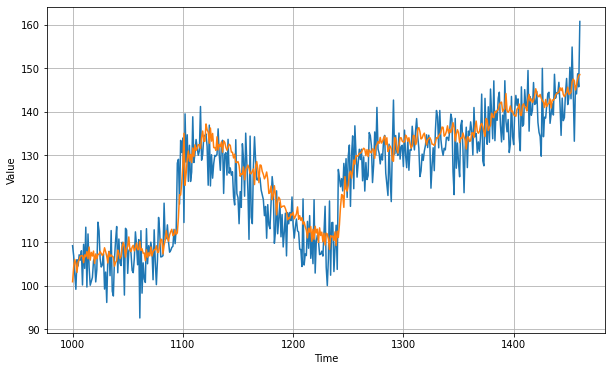

In [20]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8276453